# 编程练习2：逻辑回归

In [68]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.special import expit
from scipy.optimize import fmin_ncg 

## 1. 逻辑回归
本章的练习是对一名学生两门课程的得分和大学录取情况进行学习和预测。
### 1.1 数据读取和可视化
继续良好习惯，写算法前先把数据可视化出来看一下。

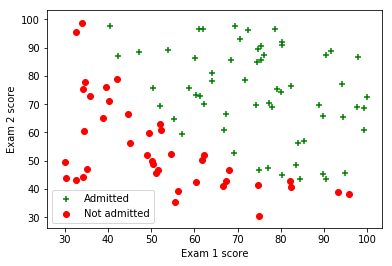

In [69]:
raw_data = np.loadtxt('ex2data1.txt', delimiter=',')
m = len(raw_data)
pos = raw_data[np.where(raw_data[:,-1]==1)]
neg = raw_data[np.where(raw_data[:,-1]==0)]
fig,ax = plt.subplots()
ax.scatter(pos[:,0], pos[:,1], c='g', marker='+', label='Admitted')
ax.scatter(neg[:,0], neg[:,1], c='r', marker='o', label='Not admitted')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()
plt.show()
X = np.mat(list(zip(np.ones(m), raw_data[:,0], raw_data[:,1])))
y = np.mat(raw_data[:,2]).reshape(m,1)

### 1.2 算法实现
#### 1.2.1 Sigmoid函数
sigmoid函数我们直接使用了内置的，即`expit`函数。
#### 1.2.2 代价函数和梯度
实现代价函数和梯度，同样，关键是用矩阵形式表示：
$$J(\theta)=\frac{1}{m}[-log(h_{\theta}(X))^Ty-log(1-h_{\theta}(X))^T(1-y)]$$  
$$\frac{{\partial}J(\theta)}{\partial\theta}=\frac{1}{m}X^T(h_{\theta}(X)-y)$$

In [70]:
def costFunction(theta, X, y):
    m = len(y)
    h_theta = expit(X*theta)
    J = (-np.log(h_theta.T)*y - np.log(1-h_theta.T)*(1-y)) / m
    grad = X.T * (h_theta-y) / m
    return J[0,0], grad
theta = np.zeros((3,1),)
J, grad = costFunction(theta, X, y)
print('Initial J(theta): %s' % J)

Initial J(theta): 0.69314718056


#### 1.2.3 参数学习
Octave的实现中，对theta的学习使用了函数`fminunc`。Python中也是有相应的方法的：`fmin_ncg`。  
问题是，`fmin_ncg`中theta和梯度都要求是行向量，因此需要特殊处理。

In [71]:
def f(x, *args):
    X, y = args
    theta = np.mat(x).reshape((X.shape[1],1))
    J, grad = costFunction(theta, X, y)
    return J
def fprime(x, *args):
    X, y = args
    theta = np.mat(x).reshape((X.shape[1],1))
    J, grad = costFunction(theta, X, y)
    return grad.getA1()
theta = fmin_ncg(f=f, x0=np.zeros(3), fprime=fprime, args=(X,y), maxiter=100)
print('Final theta: %s'%theta)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 28
         Function evaluations: 73
         Gradient evaluations: 244
         Hessian evaluations: 0
Final theta: [-25.161465     0.20623276   0.20147266]


#### 1.2.4 结果评估
进行结果评估有两种方法。  
一是把决策边界画出来，直观感受一下。  
二是计算一下准确率。

Accuracy: 0.89


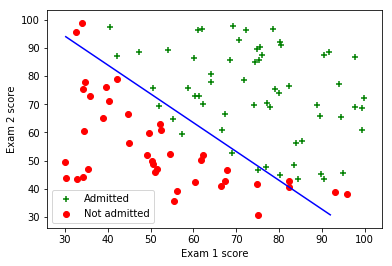

In [72]:
theta = np.mat(theta).reshape((3,1))
accuracy = np.mean(np.round(expit(X*theta)) == y)
print('Accuracy: %s'%accuracy)
fig,ax = plt.subplots()
xdata = [np.min(raw_data[:,0]), np.max(raw_data[:,0])]
ydata = [np.min(raw_data[:,1]), np.max(raw_data[:,1])]
xdata, ydata = np.meshgrid(xdata, ydata)
ax.contour(xdata, ydata, theta[0,0]+theta[1,0]*xdata+theta[2,0]*ydata, [0], colors='blue')
ax.scatter(pos[:,0], pos[:,1], c='g', marker='+', label='Admitted')
ax.scatter(neg[:,0], neg[:,1], c='r', marker='o', label='Not admitted')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()
plt.show()

## 2. 正则化逻辑回归
本章的练习是对芯片测试的数据和是否通过产检进行学习和预测。
### 2.1 数据读取和可视化
继续良好习惯，写算法前先把数据可视化出来看一下。

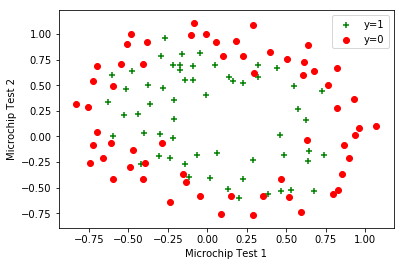

In [73]:
raw_data = np.loadtxt('ex2data2.txt', delimiter=',')
m = len(raw_data)
pos = raw_data[np.where(raw_data[:,-1]==1)]
neg = raw_data[np.where(raw_data[:,-1]==0)]
fig,ax = plt.subplots()
ax.scatter(pos[:,0], pos[:,1], c='g', marker='+', label='y=1')
ax.scatter(neg[:,0], neg[:,1], c='r', marker='o', label='y=0')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend()
plt.show()

### 2.2 特征映射
为更好地进行拟合，需要将特征映射到高阶。这里讲X从1阶映射到最高6阶。

In [74]:
max_power = 6
def mapFeature(u, v, max_power):
    X = []
    for p in range(0, max_power+1):
        for i in range(0, p+1):
            X.append(np.power(u,i) * np.power(v,p-i))
    return np.mat(X).T
X = mapFeature(raw_data[:,0], raw_data[:,1], max_power)
y = np.mat(raw_data[:,2]).reshape(m,1)

### 2.3 正则化代价函数及梯度
假设
$$\theta^*=[0,\theta_1,...\theta_n]^T$$  
则矩阵形式表示：  
$$J(\theta)=\frac{1}{m}[-log(h_{\theta}(X))^Ty-log(1-h_{\theta}(X))^T(1-y)]+\frac{\lambda}{2m}\theta^{*T}\theta^*$$
$$\frac{{\partial}J(\theta)}{\partial\theta}=\frac{1}{m}X^T(h_{\theta}(X)-y)+\frac{\lambda}{m}\theta^*$$

In [75]:
def costFunctionReg(theta, X, y, lamda):
    m = len(y)
    theta0 = theta.copy()
    theta0[0,0] = 0
    h_theta = expit(X*theta)
    J = (-np.log(h_theta.T)*y - np.log(1-h_theta.T)*(1-y)) / m + lamda/(2*m)*theta0.T*theta0
    grad = X.T * (h_theta-y) / m + lamda/m*theta0
    return J[0,0], grad
theta = np.zeros((X.shape[1],1),)
lamda = 1 
J, grad = costFunctionReg(theta, X, y, lamda)
print('Initial J(theta): %s'%J)

Initial J(theta): 0.69314718056


#### 2.3.1 参数学习
像之前一样，我们用`fmin_ncg`求取最小化代价函数的参数。

In [76]:
def freg(x, *args):
    X, y, lamda = args
    theta = np.mat(x).reshape((X.shape[1],1))
    J, grad = costFunctionReg(theta, X, y, lamda)
    return J
def fprimereg(x, *args):
    X, y, lamda = args
    theta = np.mat(x).reshape((X.shape[1],1))
    J, grad = costFunctionReg(theta, X, y, lamda)
    return grad.getA1()
theta = fmin_ncg(f=freg, x0=np.zeros(X.shape[1]), fprime=fprimereg, args=(X,y,lamda), maxiter=100)
print('Final theta: %s'%theta)

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 62
         Hessian evaluations: 0
Final theta: [ 1.27274011  1.18109091  0.62527119 -1.43166564 -0.91742415 -2.01995954
 -0.17513005 -0.357238   -0.36553347  0.12400759 -1.19281782 -0.2747066
 -0.6155587  -0.05099004 -1.45815852 -0.45635861 -0.29537718 -0.27778523
 -0.04473181 -0.20600473 -0.24218752 -0.92465495 -0.14388708 -0.32738091
  0.01556596 -0.29243289  0.02777165 -1.04320498]


### 2.4 绘制决策边界

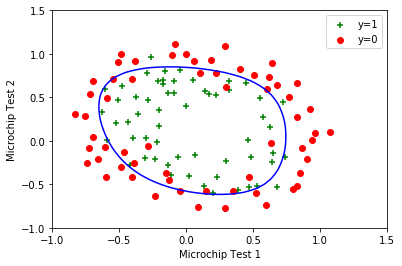

In [77]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
U,V = np.meshgrid(u, v)
theta = np.mat(theta).reshape((X.shape[1],1))
J_vals = (mapFeature(U.flatten(), V.flatten(), max_power) * theta).reshape(len(u), len(v))
fig,ax = plt.subplots()
ax.scatter(pos[:,0], pos[:,1], c='g', marker='+', label='y=1')
ax.scatter(neg[:,0], neg[:,1], c='r', marker='o', label='y=0')
ax.contour(U, V, J_vals, [0], colors='blue')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend()
plt.show()

### 2.5 不同正则化参数的影响
取lambda=0（过拟合）和lambda=100，观察决策边界的变化。

         Current function value: 0.273073
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 1635
         Hessian evaluations: 0


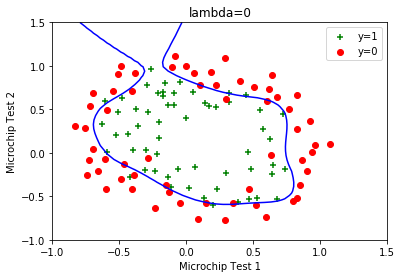

Optimization terminated successfully.
         Current function value: 0.686484
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 18
         Hessian evaluations: 0


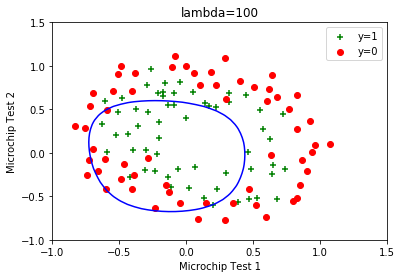

In [78]:
for lamda in [0,100]:
    theta = fmin_ncg(f=freg, x0=np.zeros(X.shape[1]), fprime=fprimereg, args=(X,y,lamda), maxiter=100)
    theta = np.mat(theta).reshape((X.shape[1],1))
    J_vals = (mapFeature(U.flatten(), V.flatten(), max_power) * theta).reshape(len(u), len(v))
    fig,ax = plt.subplots()
    ax.scatter(pos[:,0], pos[:,1], c='g', marker='+', label='y=1')
    ax.scatter(neg[:,0], neg[:,1], c='r', marker='o', label='y=0')
    ax.contour(U, V, J_vals, [0], colors='blue')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.title('lambda=%s' % lamda)
    plt.legend()
    plt.show()